In [1]:
pwd

'/home/myhwang/deep-learning-from-scratch-3'

In [3]:
from dezero import *
import contextlib
import numpy as np
import graphviz
import dezero.functions as F
import dezero.layers as L
from dezero import optimizers


# II. 신경망 만들기
***

## 0. cuda.py 파일 만들기

_xp = cuda.get_array_module(x)_ 이런 함수를 자주보게 되는데 한참뒤에 단계에서 구현하는 함수라서 <br>출판사 측에서 올려준 코드에서 일일이 변경해서 코드를 짠뒤 다시 나중에 복원 해야하므로 <br>미리 아래 주석처리 해둔 내용으로 'cuda.py'를 구현해두고 다음 파트들을 학습할 것을 추천함


In [ ]:
#xp = cuda.get_array_module(x) 이런 함수를 자주보게 되는데 현재 단계에서 구현되지 않은 함수라서 올려준 코드에서 일일이 변경해서 코드를 짠뒤 다시 나중에 복원 해야하므로
# from dezero import Variable
# import numpy as np
# gpu_enable = False
# # gpu_enable = True
# # try:
# #     import cupy as cp
# #     cupy = cp
# # except ImportError:
# #     gpu_enable = False

# def get_array_module(x):
#     """Returns the array module for `x`.

#     Args:
#         x (dezero.Variable or numpy.ndarray or cupy.ndarray): Values to
#             determine whether NumPy or CuPy should be used.

#     Returns:
#         module: `cupy` or `numpy` is returned based on the argument.
#     """
#     if isinstance(x, Variable):
#         x = x.data

#     if not gpu_enable:
#         return np
#     xp = cp.get_array_module(x)
#     return xp

## 1. 기존 패키지가 텐서자료에도 적용 되는가?

스칼라

In [ ]:
x=Variable(np.array(1.))
y=F.sin(x)
print(y)

variable(0.8414709848078965)


행렬

In [ ]:
x=Variable(np.array([[1,2,3],[4,5,6]]))
y=F.sin(x)
print(y)

variable([[ 0.84147098  0.90929743  0.14112001]
          [-0.7568025  -0.95892427 -0.2794155 ]])


행렬 + 스칼라

In [ ]:
x=Variable(np.array([[1,2,3],[4,5,6]]))
c=Variable(np.array([[10,20,30],[40,50,60]]))
y=x+c
print(y)

variable([[11 22 33]
          [44 55 66]])


## 2. 형상변환 함수

reshape 함수 구현

In [4]:
x=np.array([[1,2,3],[4,5,6]])
y=np.reshape(x,(6,))

print(y)

[1 2 3 4 5 6]


In [4]:
# class Reshape(Function):
#     def __init__(self, shape):
#         self.shape = shape

#     def forward(self, x):
#         self.x_shape = x.shape
#         y = x.reshape(self.shape)
#         return y

#     def backward(self, gy):
#         return reshape(gy, self.x_shape)


# def reshape(x, shape):
#     if x.shape == shape:
#         return as_variable(x)
#     # f=Reshape(shape)
#     # return f(x)
#     return Reshape(shape)(x)

x=Variable(np.array([[1,2,3],[4,5,6]]))
y=F.reshape(x,(6,))
y.backward(retain_grad=True)

print(y)
print(x.grad)

variable([1 2 3 4 5 6])
variable([[1 1 1]
          [1 1 1]])


편의성 패치

In [8]:
#numpy의 reshape
x=np.random.rand(1,2,3)

y=x.reshape((2,3)) #튜플로 받기
y=x.reshape([2,3]) #리스트로 받기
y=x.reshape(2,3) #인수를 풀어서 받기

In [4]:
# # reshape 입력 편의성을 위한 코드 core.py의 class Variable에 추가
# def reshape(self, *shape):
#     if len(shape) == 1 and isinstance(shape[0], (tuple, list)):
#         shape = shape[0]
#     return dezero.funtions.reshape(self, shape)

x=Variable(np.random.rand(1,2,3))

y=x.reshape((2,3)) #튜플로 받기
y=x.reshape([2,3]) #리스트로 받기
y=x.reshape(2,3) #인수를 풀어서 받기

transpose 함수 구현

In [6]:
x=np.array([[1,2,3],[4,5,6]])
y=np.transpose(x)

print(y)

[[1 4]
 [2 5]
 [3 6]]


In [ ]:
# class Transpose(Function):
#     def forward(self, x):
#         y = np.transpose(x)
#         return y

#     def backward(self, gy):
#         gx = transpose(gy)
#         return gx


# def transpose(x):
#     f = Transpose()
#     return f(x)

x=Variable(np.array([[1,2,3],[4,5,6]]))
y=F.transpose(x)
y.backward(retain_grad=True)

print(y)
print(x.grad)

variable([1 2 3 4 5 6])
variable([[1 1 1]
          [1 1 1]])


편의성 패치

In [21]:
# # transpose 입력 편의성을 위한 코드 core.py의 class Variable에 추가
# def transpose(self):
#     return dezero.functions.transpose(self)
#
# @property
# def T(self):
#     return dezero.functions.transpose(self)

x=Variable(np.random.rand(2,3))

y=x.transpose() 
y=x.T()
y=x.T # @property

y=F.transpose(x)
y.data
print(x.data.shape, y.shape)


(2, 3) (3, 2)


데이터 구조 순서 변경

numpy

In [6]:
A, B, C, D =1,2,3,4
x=np.random.rand(A,B,C,D)
y=x.transpose(1,0,3,2)

print(x)
print(x.shape)
print('\n')
print(y)
print(y.shape)

[[[[0.62492053 0.34837898 0.08979581 0.16201332]
   [0.66160309 0.93933077 0.68230613 0.92872977]
   [0.07879896 0.04240806 0.52253779 0.81951213]]

  [[0.28829795 0.59486033 0.75372237 0.45591727]
   [0.51402042 0.75263629 0.16519023 0.15963545]
   [0.23740602 0.18873385 0.7978057  0.82055843]]]]
(1, 2, 3, 4)


[[[[0.62492053 0.66160309 0.07879896]
   [0.34837898 0.93933077 0.04240806]
   [0.08979581 0.68230613 0.52253779]
   [0.16201332 0.92872977 0.81951213]]]


 [[[0.28829795 0.51402042 0.23740602]
   [0.59486033 0.75263629 0.18873385]
   [0.75372237 0.16519023 0.7978057 ]
   [0.45591727 0.15963545 0.82055843]]]]
(2, 1, 4, 3)


In [ ]:
# # transpose 구조 순서 변경을 위한 코드 functions.py의 class 수정
# class Transpose(Function):
#     def __init__(self, axes=None):
#         self.axes = axes

#     def forward(self, x):
#         y = x.transpose(self.axes)
#         return y

#     def backward(self, gy):
#         if self.axes is None:
#             return transpose(gy)

#         axes_len = len(self.axes)
#         inv_axes = tuple(np.argsort([ax % axes_len for ax in self.axes]))
#         return transpose(gy, inv_axes)
#
# def transpose(x, axes=None):
#     return Transpose(axes)(x)



# # transpose 구조 순서 변경을 위한 코드 core.py의 class Variable에 수정
#
# def transpose(self, *axes):
#     if len(axes) == 0:
#         axes = None
#     elif len(axes) == 1:
#         if isinstance(axes[0], (tuple, list)) or axes[0] is None:
#             axes = axes[0]
#     return dezero.functions.transpose(self, axes)

In [6]:
A, B, C, D =1,2,3,4
x=Variable(np.random.rand(A,B,C,D))
y=x.transpose(1,0,3,2)

print(x.data)
print(x.shape)
print('\n')
print(y.data)
print(y.shape)


[[[[0.33495746 0.99285864 0.64429329 0.73883322]
   [0.91049988 0.29999847 0.75331492 0.16324055]
   [0.79819818 0.08766936 0.32783892 0.26212729]]

  [[0.94827607 0.51457012 0.84246428 0.71420237]
   [0.41365796 0.46076555 0.48962624 0.43056031]
   [0.96835464 0.60271868 0.71956376 0.70118926]]]]
(1, 2, 3, 4)


[[[[0.33495746 0.91049988 0.79819818]
   [0.99285864 0.29999847 0.08766936]
   [0.64429329 0.75331492 0.32783892]
   [0.73883322 0.16324055 0.26212729]]]


 [[[0.94827607 0.41365796 0.96835464]
   [0.51457012 0.46076555 0.60271868]
   [0.84246428 0.48962624 0.71956376]
   [0.71420237 0.43056031 0.70118926]]]]
(2, 1, 4, 3)


## 3. 행렬 합, Broadcasting

sum 함수
- 기울기를 입력 변수의 형상과 같아지도록 복사하는 것이 중점

In [ ]:
# class Sum(Function):
#     def forward(self, x):
#         self.x_shape = x.shape
#         y = x.sum()
#         return y

#     def backward(self, gy):
#         gx = broadcst_to(gy, self.x_shape)
#         return gx


# def sum(x):
#     f = Sum()
#     return f(x)

In [2]:
x=Variable(np.array([[1,2,3],[4,5,6]]))
y=F.sum(x)

print(y)

variable(21)


axis와 keepdims 관련 sum 기능 구현

In [ ]:
# # functions.py의 class 수정
# class Sum(Function):

#     def __init__(self, axis, keepdims):
#         self.axis = axis
#         self.keepdims = keepdims

#     def forward(self, x):
#         self.x_shape = x.shape
#         y = x.sum(axis=self.axis, keepdims=self.keepdims)
#         return y

#     def backward(self, gy):
#         gy = utils.reshape_sum_backward(
#             gy, self.x_shape, self.axis, self.keepdims)

#         gx = broadcst_to(gy, self.x_shape)
#         return gx


# def sum(x, axis=None, keepdims=False):
#     # f = Sum(axis,keepdims)
#     # return f(x)
#     return Sum(axis, keepdims)(x)


# # core.py의 class Variable 수정
# def sum(self, axis=None, keepdims=False):
#     return dezero.functions.sum(self, axis, keepdims)

In [2]:
#axis
x=Variable(np.array([[1,2,3],[4,5,6]]))
y=F.sum(x,axis=0)
y.backward()
print(y)
print(x.grad)

variable([5 7 9])
variable([[1 1 1]
          [1 1 1]])


In [3]:
#keepdims & class Variable x.sum()
x=Variable(np.random.randn(2,3,4,5))
y=x.sum(keepdims=True)
print(y.shape)

(1, 1, 1, 1)


broadcast_to, sum_to 함수

In [5]:
x=np.array([1,2,3])
y=np.broadcast_to(x,(2,3))

print(x)
print(y)

[1 2 3]
[[1 2 3]
 [1 2 3]]


In [ ]:
# #############################################################


# class BroadcastTO(Function):

#     def __init__(self, shape):
#         self.shape = shape

#     def forward(self, x):
#         self.x_shape = x.shape
#         y = np.broadcast_to(x, self.shape)
#         return y

#     def backward(self, gy):
#         gx = sum_to(gy, self.x_shape)
#         return gx


# def broadcast_to(x, shape):
#     if x.shape == shape:
#         return as_variable(x)
#     return BroadcastTO(shape)(x)


# #############################################################


# class SumTo(Function):
#     def __init__(self, shape):
#         self.shape = shape

#     def forward(self, x):
#         self.x_shape = x.shape
#         y = utils.sum_to(x, self.shape)
#         return y

#     def backward(self, gy):
#         gx = broadcast_to(gy, self.x_shape)
#         return gx


# def sum_to(x, shape):
#     if x.shape == shape:
#         return as_variable(x)
#     return SumTo(shape)(x)

In [2]:
x0=Variable(np.array([1,2,3]))
x1=Variable(np.array([10]))
y=x0+x1

print(y)

y.backward()
print(x1.grad)


variable([11 12 13])
variable([3])


## 4. 내적

numpy

In [4]:
a=np.array([1,2,3])
b=np.array([4,5,6])
c=np.dot(a,b)
print(c)

a=np.array([[1,2],[3,4]])
b=np.array([[5,6],[7,8]])
c=np.dot(a,b)
print(c)


32
[[19 22]
 [43 50]]


In [4]:
# class MatMul(Function):
#     def forward(self, x, W):
#         y = x.dot(W)
#         return y

#     def backward(self, gy):
#         x, W = self.inputs
#         gx = matmul(gy, W.T)
#         gW = matmul(x.T, gy)
#         return gx, gW


# def matmul(x, W):
#     f = MatMul()
#     return f(x, W)

x=Variable(np.random.randn(2,3))
W=Variable(np.random.randn(3,4))
y=F.matmul(x,W)
y.backward()

print(y.shape)
print(x.grad.shape, W.grad.shape)


(2, 4)
(2, 3) (3, 4)


## 5. 선형회귀

toy dataset

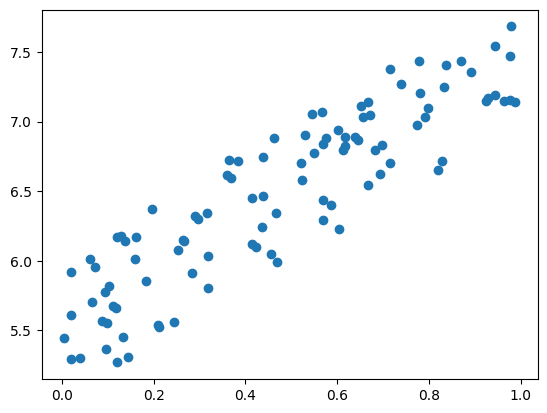

In [9]:
import matplotlib.pyplot as plt

np.random.seed(0)
x=np.random.rand(100,1)
y=5 + 2 * x + np.random.rand(100,1)

plt.scatter(x,y)


In [47]:
np.random.seed(0)
x=np.random.rand(100,1)
y=5 + 2 * x + np.random.rand(100,1)
x,y= Variable(x), Variable(y)

W=Variable(np.zeros((1,1)))
b=Variable(np.zeros(1))

def predict(x):
    y = F.matmul(x,W) + b
    return y

def mean_squared_error(x0,x1):
    diff = x0 - x1
    return F.sum(diff**2) / len(diff)

lr = 0.1
iters = 100

for i in range(iters):
    y_pred= predict(x)
    loss=mean_squared_error(y,y_pred)

    W.cleargrad()
    b.cleargrad()
    loss.backward()

    W.data -= lr*W.grad.data
    b.data -= lr*b.grad.data

    print(W,b,loss)

variable([[0.64433458]]) variable([1.29473389]) variable(42.296340129442335)
variable([[1.12672345]]) variable([2.26959351]) variable(23.97380754378544)
variable([[1.48734571]]) variable([3.00386712]) variable(13.609686745040522)
variable([[1.75641886]]) variable([3.557186]) variable(7.747049961219976)
variable([[1.95666851]]) variable([3.97439789]) variable(4.43057410592155)
variable([[2.10518573]]) variable([4.28923203]) variable(2.554280381353593)
variable([[2.21482401]]) variable([4.52705574]) variable(1.492599869047195)
variable([[2.29524981]]) variable([4.70694745]) variable(0.8916952181756939)
variable([[2.35373273]]) variable([4.84325585]) variable(0.5514270962227455)
variable([[2.39573972]]) variable([4.9467725]) variable(0.3585915308319281)
variable([[2.425382]]) variable([5.02561369]) variable(0.24915731977561134)
variable([[2.44575118]]) variable([5.08588371]) variable(0.1869065876539789)
variable([[2.45917205]]) variable([5.13217364]) variable(0.1513533629631488)
variable(

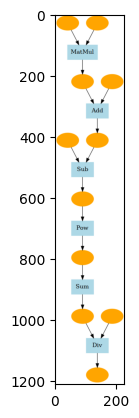

In [48]:
import matplotlib.pyplot as plt
from dezero.utils import plot_dot_graph
from PIL import Image


plot_dot_graph(loss, verbose=False, to_file='lin1.png')
img1=Image.open('/home/myhwang/deep-learning-from-scratch-3/lin1.png')
plt.imshow(img1)
plt.show()

variable([[2.11807369]]) variable([5.46608905])


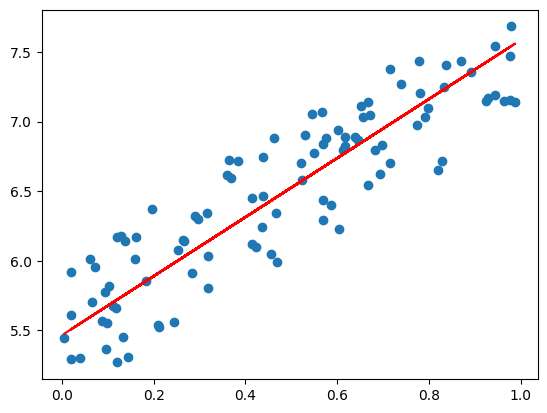

In [38]:
import matplotlib.pyplot as plt

print(W,b)
plt.scatter(x.data,y.data)
plt.plot(x.data, W.data[0] * x.data + b.data[0], color='red')

In [3]:
# def linear_simple(x,W, b=None):
#     t=matmul(x,W)
#     if b is None:
#         return t
    
#     y= t+b
#     t.data=None
#     return y

# class MeanSquaredError(Function):
#     def forward(self, x0, x1):
#         diff = x0 - x1
#         y = (diff**2).sum() / len(diff)
#         return y

#     def backward(self, gy):
#         x0, x1 = self.inputs
#         diff = x0 - x1
#         gx0 = gy * diff * (2. / len(diff))
#         gx1 = -gx0  # x1은 상수
#         return gx0, gx1

# def mean_squared_error(x0, x1):
#     return MeanSquaredError()(x0, x1)


np.random.seed(0)
x=np.random.rand(100,1)
y=5 + 2 * x + np.random.rand(100,1)
x,y= Variable(x), Variable(y)

W=Variable(np.zeros((1,1)))
b=Variable(np.zeros(1))

def predict(x, W, b):
    y = F.linear_simple(x, W, b)
    return y



lr = 0.1
iters = 100

for i in range(iters):
    y_pred= predict(x,W,b)
    loss=F.mean_squared_error(y,y_pred)

    W.cleargrad()
    b.cleargrad()
    loss.backward()

    W.data -= lr*W.grad.data
    b.data -= lr*b.grad.data

    print(W,b,loss)

variable([[0.64433458]]) variable([1.29473389]) variable(42.296340129442335)
variable([[1.12672345]]) variable([2.26959351]) variable(23.97380754378544)
variable([[1.48734571]]) variable([3.00386712]) variable(13.609686745040522)
variable([[1.75641886]]) variable([3.557186]) variable(7.747049961219976)
variable([[1.95666851]]) variable([3.97439789]) variable(4.43057410592155)
variable([[2.10518573]]) variable([4.28923203]) variable(2.554280381353593)
variable([[2.21482401]]) variable([4.52705574]) variable(1.492599869047195)
variable([[2.29524981]]) variable([4.70694745]) variable(0.8916952181756939)
variable([[2.35373273]]) variable([4.84325585]) variable(0.5514270962227455)
variable([[2.39573972]]) variable([4.9467725]) variable(0.3585915308319281)
variable([[2.425382]]) variable([5.02561369]) variable(0.24915731977561134)
variable([[2.44575118]]) variable([5.08588371]) variable(0.1869065876539789)
variable([[2.45917205]]) variable([5.13217364]) variable(0.1513533629631488)
variable(

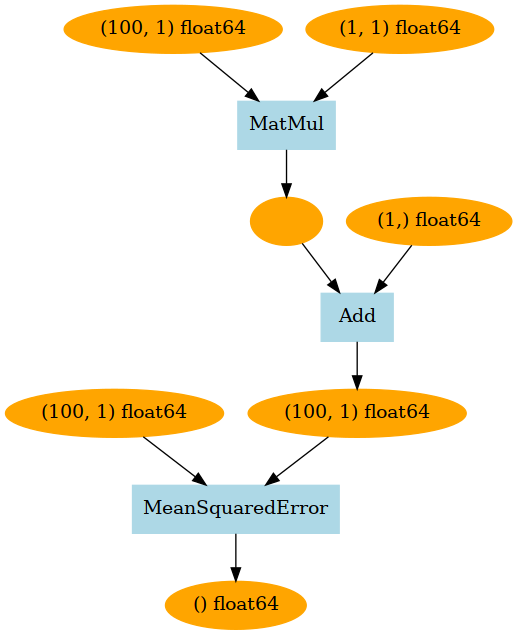

In [6]:
import matplotlib.pyplot as plt
from dezero.utils import plot_dot_graph
from PIL import Image

plot_dot_graph(loss, verbose=True, to_file='lin2.png')


## 6. 신경망 구현

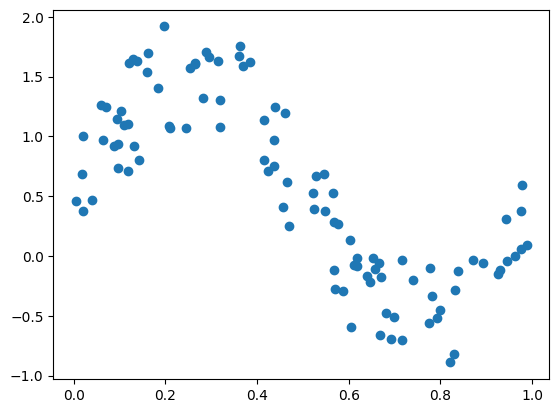

In [9]:
import matplotlib.pyplot as plt

np.random.seed(0)
x=np.random.rand(100,1)
y=np.sin(2 * np.pi * x) + np.random.rand(100,1)

plt.scatter(x,y)

In [49]:
# def sigmoid_simple(x):
#     x = as_variable(x)
#     y = 1 / (1 + exp(-x))
#     return y




#dataset
np.random.seed(0)
x=np.random.rand(100,1)
y=np.sin(2 * np.pi * x) + np.random.rand(100,1)
# x,y= Variable(x), Variable(y)




I, H, O = 1, 10, 1 # input / hidden / output

W1=Variable(0.01 * np.random.randn(I,H))
b1=Variable(np.zeros(H))

W2=Variable(0.01 * np.random.randn(H,O))
b2=Variable(np.zeros(O))

def predict(x):
    y=F.linear_simple(x,W1,b1)
    y=F.sigmoid_simple(y)
    y=F.linear_simple(y,W2,b2)
    return y

lr = 0.2
iters = 10000

for i in range(iters):
    y_pred= predict(x)
    loss=F.mean_squared_error(y,y_pred)

    W1.cleargrad()
    b1.cleargrad()
    W2.cleargrad()
    b2.cleargrad()
    loss.backward()

    W1.data -= lr*W1.grad.data
    b1.data -= lr*b1.grad.data
    W2.data -= lr*W2.grad.data
    b2.data -= lr*b2.grad.data
    if i % 1000==0:
        print(loss)

variable(0.8473695850105871)
variable(0.2514286285183606)
variable(0.2475948546674987)
variable(0.2378612044705481)
variable(0.21222231333102917)
variable(0.16742181117834143)
variable(0.09681932619992625)
variable(0.07849528290602327)
variable(0.07749729552991155)
variable(0.07722132399559314)


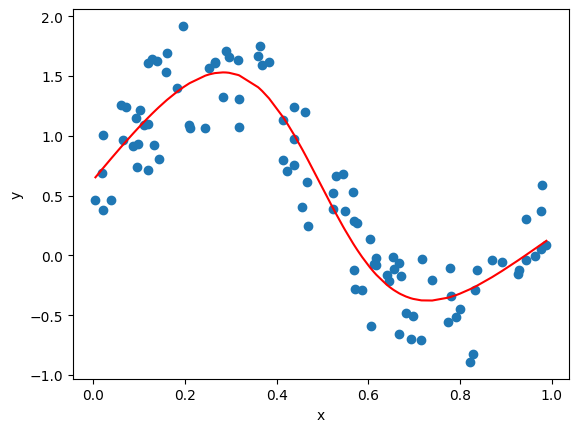

In [57]:
import matplotlib.pyplot as plt
indices = x.ravel().argsort()
x = x[indices]
y = y[indices]

y_pred = predict(x)


plt.plot(x,y_pred.data,color='r')
plt.scatter(x,y)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

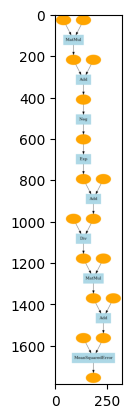

In [51]:
import matplotlib.pyplot as plt
from dezero.utils import plot_dot_graph
from PIL import Image

plot_dot_graph(loss, verbose=False, to_file='sin.png')
img1=Image.open('/home/myhwang/deep-learning-from-scratch-3/sin.png')
plt.imshow(img1)
plt.show()

## 7. 매개변수

In [2]:
# class Parameter(Variable):
#     pass

x=Variable(np.array(1.))
p=Parameter(np.array(2.))
y=x*p

print(isinstance(p, Parameter))
print(isinstance(x, Parameter))
print(isinstance(y, Parameter))

True
False
False


In [5]:
from dezero.core import Parameter


class Layer:
    def __init__(self):
        self._params = set()

    def __setattr__(self, name, value):
        if isinstance(value, Parameter):
            self._params.add(name)
        super().__setattr__(name, value)

layer = Layer()

layer.p1=Parameter(np.array(1))
layer.p2=Parameter(np.array(2))
layer.p3=Parameter(np.array(3))
layer.p4='test'

print(layer._params)
print('----------')

for name in layer._params:
    print(name, layer.__dict__[name])


{'p1', 'p3', 'p2'}
----------
p1 variable(1)
p3 variable(3)
p2 variable(2)


layer class 구현

In [ ]:
# class Layer:
#     def __init__(self):
#         self._params = set()

#     def __setattr__(self, name, value):
#         if isinstance(value, Parameter):
#             self._params.add(name)
#         super().__setattr__(name, value)  # 무한 루프 재귀를 막기 위한 코드

#     def __call__(self, *inputs):
#         outputs = self.forward(*inputs)
#         if not isinstance(outputs, tuple):
#             outputs = (outputs,)

#         self.inputs = [weakref.ref(x) for x in inputs]  # 약한 참조
#         self.outputs = [weakref.ref(y) for x in outputs]  # 약한 참조
#         return outputs if len(outputs) > 1 else outputs[0]

#     def forward(self, inputs):
#         raise NotImplementedError()

#     def params(self):
#         for name in self._params:
#             yield self.__dict__[name]

#     def cleargrads(self):
#         for param in self.params():
#             param.cleargrad()

Linear class 구현

In [ ]:
class Linear(Layer):
    def __init__(self, in_size, out_size, nobias=False, dtype=np.float32):
        super.__init__()

        I, O = in_size, out_size
        W_data = np.random.randn(I,O).astype(dtype) * np.sqrt(1/I)
        self.W = Parameter(W_data, name= 'W')
        if nobias:
            self.b=None
        else:
            self.b=Parameter(np.zeros(0, dtype= dtype), name='b')
        
    def forward(self, x):
        y= F.linear_simple(x, self.W, self.b)
        return y


In [ ]:
## 실제 구현 Linear Layer
## W의 in_size를 데이터가 들어올때 알아서 조절되게 변경

# class Linear(Layer):
#     def __init__(self, out_size, nobias=False, dtype=np.float32, in_size=None):
#         super.__init__()
#         self.in_size = in_size
#         self.out_size = out_size
#         self.dtype = dtype

#         self.W = Parameter(None, name='W')
#         if self.in_size is not None:
#             self._init_W()

#         if nobias:
#             self.b = None
#         else:
#             self.b = Parameter(np.zeros(0, dtype=dtype), name='b')

#     def _init_W(self):
#         I, O = self.in_size, self.out_size
#         W_data = np.random.randn(I, O).astype(self.dtype) * np.sqrt(1/I)
#         self.W = Parameter(W_data, name='W')

#     def forward(self, x):
#         if self.W.data is None:
#             self.in_size = x.shape[1]
#             self._init_W()

#         y = F.linear_simple(x, self.W, self.b)
#         return y

Layer를 이용한 신경망 구현

In [4]:
np.random.seed(0)
x=np.random.rand(100, 1)
y=np.sin(2 * np.pi * x) + np.random.rand(100, 1)

l1=L.Linear(10)
l2=L.Linear(1)

def predict(x):
    y=l1(x)
    y=F.sigmoid_simple(y)
    y=l2(y)
    return y

lr = 0.2
iters = 10000
for i in range(iters):
    y_pred = predict(x)
    loss = F.mean_squared_error(y, y_pred)

    l1.cleargrads()
    l2.cleargrads()
    loss.backward()

    for l in [l1,l2]:
        for p in l.params():
            p.data -= lr*p.grad.data

    if i % 1000 == 0:
        print(loss)
    

variable(0.8165178492839196)
variable(0.24990280802148895)
variable(0.24609876581126014)
variable(0.23721590814318072)
variable(0.20793216413350174)
variable(0.1231190572064935)
variable(0.0788816650635515)
variable(0.07655073683421632)
variable(0.07637803086238222)
variable(0.07618764131185574)


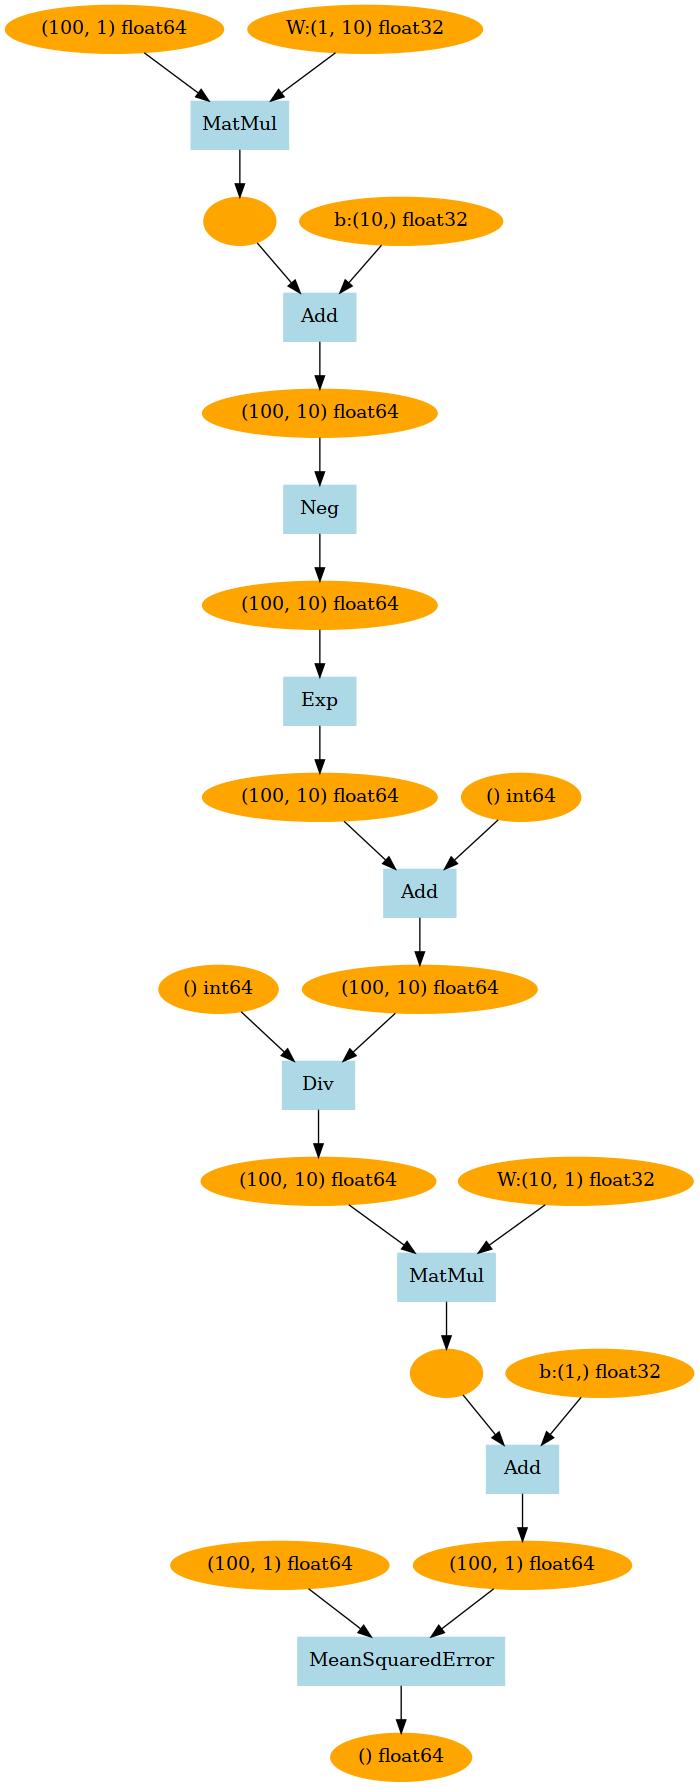

In [6]:
import matplotlib.pyplot as plt
from dezero.utils import plot_dot_graph
from PIL import Image

plot_dot_graph(loss, verbose=True, to_file='sin2.png')


Layer 안에 Layer 담기

In [44]:
# class Layer:
#     def __init__(self):
#         self._params = set()

#     def __setattr__(self, name, value):
#         if isinstance(value, (Parameter, Layer)): # *변경점 1
#             self._params.add(name)
#         super().__setattr__(name, value)  # 무한 루프 재귀를 막기 위한 코드

#     def __call__(self, *inputs):
#         outputs = self.forward(*inputs)
#         if not isinstance(outputs, tuple):
#             outputs = (outputs,)

#         self.inputs = [weakref.ref(x) for x in inputs]  # 약한 참조
#         self.outputs = [weakref.ref(y) for y in outputs]  # 약한 참조
#         return outputs if len(outputs) > 1 else outputs[0]

#     def forward(self, inputs):
#         raise NotImplementedError()

#     def params(self):
#         for name in self._params:
#             obj = self.__dict__[name] # *변경점 2

#             if isinstance(obj, Layer): # *변경점 3 재귀적인 방식으로 Layer 속 Layer도 꺼냄
#                 yield from obj.params()
#             else:
#                 yield obj

#     def cleargrads(self):
#         for param in self.params():
#             param.cleargrad()



np.random.seed(0)
x=np.random.rand(100, 1)
y=np.sin(2 * np.pi * x) + np.random.rand(100, 1)

model = L.Layer()
model.l1=L.Linear(5)
model.l2=L.Linear(3)


def predict(x):
    y=model.l1(x)
    y=F.sigmoid_simple(y)
    y=model.l2(y)
    return y

lr = 0.2
iters = 10000
for i in range(iters):
    y_pred = predict(x)
    loss = F.mean_squared_error(y, y_pred)

    loss.backward()
    model.cleargrads()


    for p in model.params():
        p.data -= lr*p.grad.data
    # if i % 1000 == 0:
    #     print(loss)

for p in model.params():
    print(p.name,':',p)



W : variable([[ 1.5070338   1.4034598   1.3066877 ]
          [-3.1454046  -3.392878   -3.4133444 ]
          [ 0.05211385  0.35849333  0.33031943]
          [ 4.3123026   4.152761    4.143132  ]
          [-3.185647   -3.330284   -3.3085032 ]])
b : variable([0.36868525 0.5093362  0.5643348 ])
W : variable([[  1.8806964  -4.492885   -6.746034  -10.178417   -3.2989678]])
b : variable([-0.79426914 -0.14287937  2.972986    5.1024356   2.915175  ])


하나의 클래스로 모델 전체 정의하기

In [9]:
class TwoLayerNet(L.Layer):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.l1=L.Linear(hidden_size)
        self.l2=L.Linear(out_size)

    def forward(self, x):
        y=F.sigmoid_simple(self.l1(x))
        y=self.l2(y)
        return y
    
np.random.seed(0)
x=np.random.rand(100, 1)
y=np.sin(2 * np.pi * x) + np.random.rand(100, 1)

model = TwoLayerNet(10,1)

lr = 0.2
iters = 10000

for i in range(iters):
    y_pred = model(x)
    loss = F.mean_squared_error(y, y_pred)

    model.cleargrads()
    loss.backward()

    for p in model.params():
        p.data -= lr*p.grad.data

    if i % 1000 == 0:
        print(loss)



variable(0.8165178492839196)


variable(0.24990280802148895)
variable(0.24609876581126014)
variable(0.23721590814318072)
variable(0.20793216413350174)
variable(0.1231190572064935)
variable(0.0788816650635515)
variable(0.07655073683421632)
variable(0.07637803086238222)
variable(0.07618764131185574)


In [43]:
for p in model.params():
    print(p.name,':',p)

W : variable([[-0.31629583]
          [-0.4884995 ]
          [ 0.375688  ]
          [ 0.10022605]
          [ 0.2912011 ]
          [ 0.10079053]
          [ 0.27095363]
          [-0.20587237]
          [-0.32705632]
          [ 0.2155391 ]])
b : variable([0.])
W : variable([[ 1.1266359  -1.0799315  -1.1474687  -0.43782005 -0.49803245  1.929532
            0.9494208   0.08755124 -1.2254355   0.844363  ]])
b : variable([0. 0. 0. 0. 0. 0. 0. 0. 0. 0.])


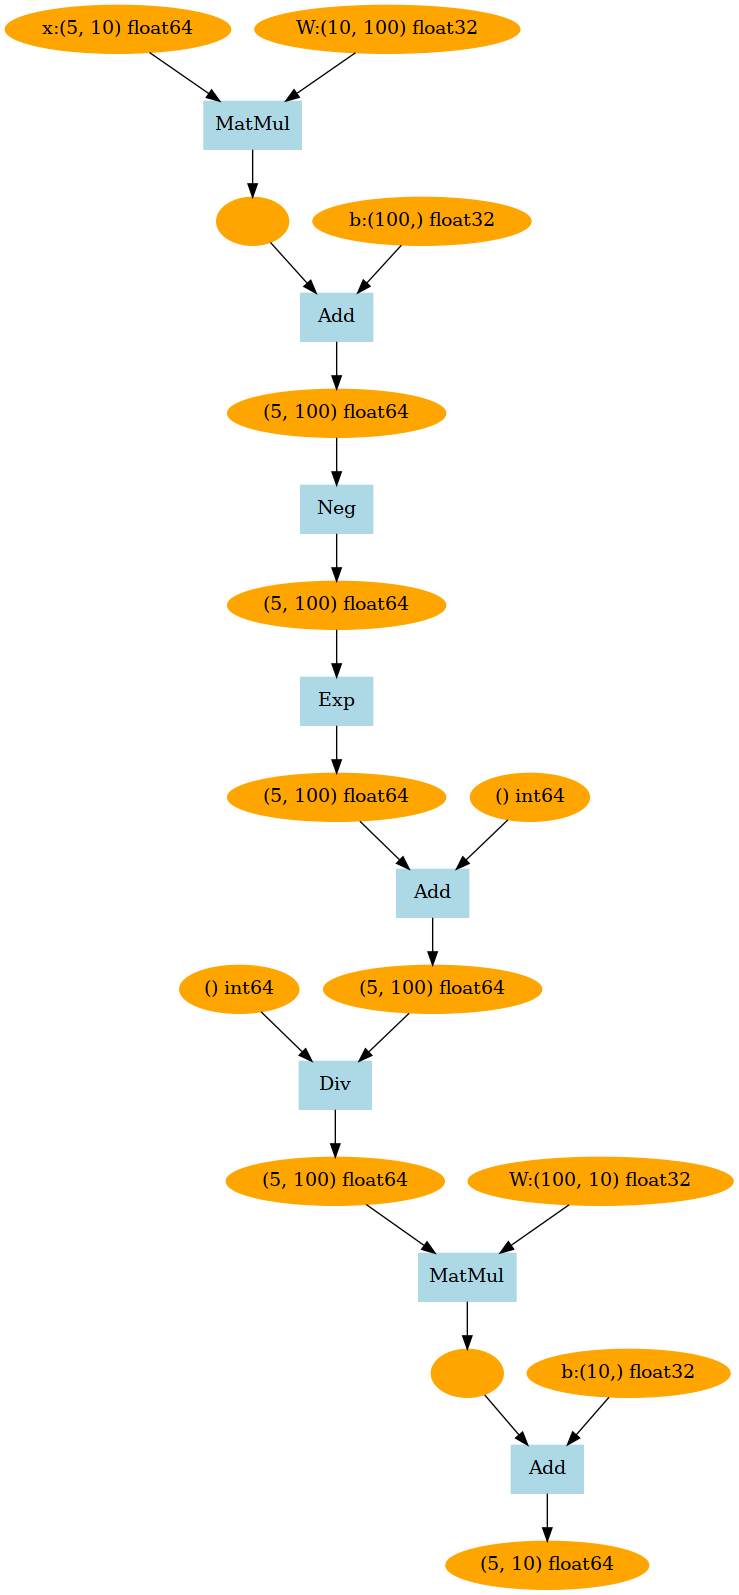

In [2]:
import numpy as np
from dezero import Variable, Model
import dezero.functions as F
import dezero.layers as L

class TwoLayerNet(Model):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.l1=L.Linear(hidden_size)
        self.l2=L.Linear(out_size)

    def forward(self, x):
        y=F.sigmoid_simple(self.l1(x))
        y=self.l2(y)
        return y
    
x=Variable(np.random.randn(5,10),name='x')
model=TwoLayerNet(100,10)
model.plot(x)
    
# Linear, Sigmoid로 안 묶이는 이유: 클래스로 바꿔둔게 아니라서 함수는 구성 연산 하나씩 그래프를 그림
#즉, linear_simple, sigmoid_simple

## 8. Optimizer

In [ ]:
# class Optimizer:
#     def __init__(self):
#         self.target = None
#         self.hooks = []

#     # model 또는 layer를 target으로 설정
#     def setup(self, target):
#         self.target = target
#         return self

#     def updata(self):
#         params = [p for p in self.target.params() if p.grad is not None]
        
#         for f in self.hooks:
#             f(params)

#         for param in params:
#             self.update_one(param)
    
#     def updata_one(self, param):
#         raise NotImplementedError()
    
#     def add_hook(self, f):
#         self.hooks.append(f)

경사하강법(SGD) 구현

In [2]:
# class SGD(Optimizer):
#     def __init__(self, lr=0.01):
#         super().__init__()
#         self.lr = lr

#     def updata_one(self, param):
#         param.data -= self.lr * param.grad.data
from dezero.models import MLP

    
np.random.seed(0)
x=np.random.rand(100, 1)
y=np.sin(2 * np.pi * x) + np.random.rand(100, 1)

lr = 0.2
iters = 10000
hidden_size = 10

model = MLP((hidden_size,1))
optimizer = optimizers.SGD(lr)
optimizer.setup(model)

for i in range(iters):
    
    y_pred = model(x)
    loss = F.mean_squared_error(y, y_pred)

    model.cleargrads()
    loss.backward()

    optimizer.update()

    if i % 1000 == 0:
        print(loss)



variable(0.8165178492839196)
variable(0.24990280802148895)
variable(0.24609876581126014)
variable(0.23721590814318072)
variable(0.20793216413350174)
variable(0.1231190572064935)
variable(0.0788816650635515)
variable(0.07655073683421632)
variable(0.07637803086238222)
variable(0.07618764131185574)


MomentumSGD 구현

In [2]:
# class MomentumSGD(Optimizer):
#     def __init__(self, lr=0.01, momentum=0.9):
#         super().__init__()
#         self.lr = lr
#         self.momentum = momentum
#         self.vs = {}

#     def update_one(self, param):
#         v_key = id(param)
#         if v_key not in self.vs:
#             self.vs[v_key] = np.zeros_like(param.data)

#         v = self.vs[v_key]
#         v *= self.momentum
#         v -= self.lr*param.grad.data
#         param.data += v
from dezero.models import MLP

    
np.random.seed(0)
x=np.random.rand(100, 1)
y=np.sin(2 * np.pi * x) + np.random.rand(100, 1)

lr = 0.2
iters = 10000
hidden_size = 10
momentum=0.9

model = MLP((hidden_size,1))
optimizer = optimizers.MomentumSGD(lr,momentum)
optimizer.setup(model)

for i in range(iters):
    
    y_pred = model(x)
    loss = F.mean_squared_error(y, y_pred)

    model.cleargrads()
    loss.backward()

    optimizer.update()

    if i % 1000 == 0:
        print(loss)


variable(0.8165178492839196)
variable(0.07743134827996005)
variable(0.07544895146731474)
variable(0.07463260305858645)
variable(0.0742098377636152)
variable(0.0739700039638533)
variable(0.07383179319278567)
variable(0.0737519831627686)
variable(0.07370578149495671)
variable(0.07367887538341847)


softmax 구현

In [6]:
from dezero.models import MLP

model=MLP((10,3))

x= np.array([[0.2,-0.4]])
y=model(x)
print(y)

variable([[-0.51222398 -0.48154886 -0.19620913]])


In [7]:
def softmax1d(x):
    x=as_variable(x)
    y=F.exp(x)
    sum_y=F.sum(y)
    return y/sum_y

x= np.array([[0.2,-0.4]])
y=model(x)
p=softmax1d(x)
print(y)
print(p)
print(p.data.sum())

variable([[-0.51222398 -0.48154886 -0.19620913]])
variable([[0.64565631 0.35434369]])
0.9999999999999999


SoftMaxCE 구현

In [2]:
# def softmax_simple(x, axis=1):
#     x = as_variable(x)
#     y = exp(x)
#     sum_y = sum(y, axis=axis, keepdims=True)
#     return y/sum_y


# def softmax_cross_entropy_simple(x, t):
#     x, t = as_variable(x), as_variable(t)
#     N = x.shape[0]  # N은 배치크기

#     p = softmax_simple(x)
#     p = clip(p, 1e-15, 1.0)
#     log_p = log(p)
#     tlog_p = log_p[np.arange(N), t.data]
#     y = -1 * sum(tlog_p) / N  # 배치 평균 계산
#     return y

#구현하려면 get_item, log, clip함수 클래스 구현 필요
from dezero.models import MLP

model=MLP((10,3))


x=np.array([[0.2,-0.4],[0.3,0.5],[1.3,-3.2],[2.1,0.3]])
t=np.array([2,0,1,0])
y=model(x)
loss=F.softmax_cross_entropy_simple(y,t)
print(loss)


variable(1.1576397521340103)


## 9. 다중 클래스 분류

epoch 1, loss 1.13
epoch 2, loss 1.05
epoch 3, loss 0.95
epoch 4, loss 0.92
epoch 5, loss 0.87
epoch 6, loss 0.89
epoch 7, loss 0.84
epoch 8, loss 0.78
epoch 9, loss 0.80
epoch 10, loss 0.79
epoch 11, loss 0.78
epoch 12, loss 0.76
epoch 13, loss 0.77
epoch 14, loss 0.76
epoch 15, loss 0.76
epoch 16, loss 0.77
epoch 17, loss 0.78
epoch 18, loss 0.74
epoch 19, loss 0.74
epoch 20, loss 0.72
epoch 21, loss 0.73
epoch 22, loss 0.74
epoch 23, loss 0.77
epoch 24, loss 0.73
epoch 25, loss 0.74
epoch 26, loss 0.74
epoch 27, loss 0.72
epoch 28, loss 0.72
epoch 29, loss 0.72
epoch 30, loss 0.73
epoch 31, loss 0.71
epoch 32, loss 0.72
epoch 33, loss 0.72
epoch 34, loss 0.71
epoch 35, loss 0.72
epoch 36, loss 0.71
epoch 37, loss 0.71
epoch 38, loss 0.70
epoch 39, loss 0.71
epoch 40, loss 0.70
epoch 41, loss 0.71
epoch 42, loss 0.70
epoch 43, loss 0.70
epoch 44, loss 0.70
epoch 45, loss 0.69
epoch 46, loss 0.69
epoch 47, loss 0.71
epoch 48, loss 0.70
epoch 49, loss 0.69
epoch 50, loss 0.69
epoch 51,

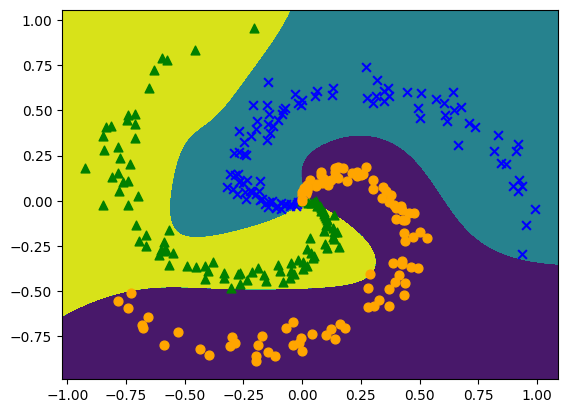

In [2]:
# dezero.datasets.get_spiral를 위해 datasets.py , transforms.py 등 여러 함수가 필요하니 확인 필요
# loss.backward()를 위해 class SoftmaxCrossEntropy 구현 필요
#따라서 class Softmax와 utils.logsumexp 함수도 구현 필요

if '__file__' in globals():
    import os, sys
    sys.path.append(os.path.join(os.path.dirname(__file__), '..'))
import math
import numpy as np
import matplotlib.pyplot as plt
import dezero
from dezero import optimizers
import dezero.functions as F
from dezero.models import MLP
from dezero.datasets import get_spiral

# Hyperparameters
max_epoch = 300
batch_size = 30
hidden_size = 10
lr = 1.0

x, t = dezero.datasets.get_spiral(train=True)
model = MLP((hidden_size, 3))
optimizer = optimizers.SGD(lr).setup(model)

data_size = len(x)
max_iter = math.ceil(data_size / batch_size)

for epoch in range(max_epoch):
    # Shuffle index for data
    index = np.random.permutation(data_size)
    sum_loss = 0

    for i in range(max_iter):
        batch_index = index[i * batch_size:(i + 1) * batch_size]
        batch_x = x[batch_index]
        batch_t = t[batch_index]

        y = model(batch_x)
        loss = F.softmax_cross_entropy(y, batch_t)
        model.cleargrads()
        loss.backward()
        optimizer.update()

        sum_loss += float(loss.data) * len(batch_t)

    # Print loss every epoch
    avg_loss = sum_loss / data_size
    print('epoch %d, loss %.2f' % (epoch + 1, avg_loss))

# Plot boundary area the model predict
h = 0.001
x_min, x_max = x[:, 0].min() - .1, x[:, 0].max() + .1
y_min, y_max = x[:, 1].min() - .1, x[:, 1].max() + .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
X = np.c_[xx.ravel(), yy.ravel()]

with dezero.no_grad():
    score = model(X)
predict_cls = np.argmax(score.data, axis=1)
Z = predict_cls.reshape(xx.shape)
plt.contourf(xx, yy, Z)

# Plot data points of the dataset
N, CLS_NUM = 100, 3
markers = ['o', 'x', '^']
colors = ['orange', 'blue', 'green']
for i in range(len(x)):
    c = t[i]
    plt.scatter(x[i][0], x[i][1], s=40,  marker=markers[c], c=colors[c])
plt.show()

## 10. dateset class

dataset class 구현

In [5]:
from dezero.datasets import get_spiral

class Dataset:
    def __init__(self, train=True):
        self.train=train
        self.data=None
        self.label=None
        self.prepare()

    def __getitem__(self, index):
        assert np.isscalar(index)
        if self.label is None:
            return self.data[index], None
        else:
            return self.data[index],self.label[index]
    
    def __len__(self):
        return len(self.data)

    def prepare(self):
        pass

class Spiral(Dataset):
    def prepare(self):
        self.data, self.label = get_spiral(self.train)

train_set = Spiral(train=True)
print(train_set[0])
print(len(train_set))


(array([-0.13981389, -0.00721657], dtype=float32), 1)
300


큰 데이터셋의 경우의 데이터셋 클래스 구현
* 클래스 초기화시 데이터를 읽지 않고 데이터에 접근할 때 읽게하는 방식

In [ ]:
class BigData(Dataset):
    def __getitem__(index):
        x= np.load('data/{}.npy'.format(index))
        t= np.load('label/{}.npy'.format(index))
        return x, t
    
    def __len__():
        return 1000000


데이터 이어 붙이기(미니 배치)

In [9]:
train_set = Spiral()

batch_index = [0, 1 ,2]
batch = [train_set[i] for i in batch_index]

x=np.array([example[0] for example in batch])
t=np.array([example[1] for example in batch])

print(x)
print(t)
print(x.shape)
print(t.shape)

[[-0.13981389 -0.00721657]
 [ 0.37049392  0.5820947 ]
 [ 0.1374263  -0.17179643]]
[1 1 2]
(3, 2)
(3,)


dataset class 사용해서 학습

In [11]:
if '__file__' in globals():
    import os, sys
    sys.path.append(os.path.join(os.path.dirname(__file__), '..'))
import math
import numpy as np
import dezero
from dezero import optimizers
import dezero.functions as F
from dezero.models import MLP
from dezero.datasets import get_spiral

# Hyperparameters
max_epoch = 300
batch_size = 30
hidden_size = 10
lr = 1.0

train_set = Spiral()

model = MLP((hidden_size, 3))
optimizer = optimizers.SGD(lr).setup(model)

data_size = len(x)
max_iter = math.ceil(data_size / batch_size)

for epoch in range(max_epoch):
    # Shuffle index for data
    index = np.random.permutation(data_size)
    sum_loss = 0

    for i in range(max_iter):
        # 달라진 부분(시작)
        batch_index = index[i * batch_size:(i + 1) * batch_size]
        batch = [train_set[i] for i in batch_index]

        batch_x=np.array([example[0] for example in batch])
        batch_t=np.array([example[1] for example in batch])
        # 달라진 부분(끝)

        y = model(batch_x)
        loss = F.softmax_cross_entropy(y, batch_t)
        model.cleargrads()
        loss.backward()
        optimizer.update()

        sum_loss += float(loss.data) * len(batch_t)

    # Print loss every epoch
    avg_loss = sum_loss / data_size
    print('epoch %d, loss %.2f' % (epoch + 1, avg_loss))

epoch 1, loss 1.08
epoch 2, loss 0.76
epoch 3, loss 0.71
epoch 4, loss 0.69
epoch 5, loss 0.67
epoch 6, loss 0.66
epoch 7, loss 0.65
epoch 8, loss 0.64
epoch 9, loss 0.63
epoch 10, loss 0.63
epoch 11, loss 0.62
epoch 12, loss 0.61
epoch 13, loss 0.61
epoch 14, loss 0.60
epoch 15, loss 0.59
epoch 16, loss 0.58
epoch 17, loss 0.58
epoch 18, loss 0.57
epoch 19, loss 0.56
epoch 20, loss 0.56
epoch 21, loss 0.55
epoch 22, loss 0.54
epoch 23, loss 0.53
epoch 24, loss 0.53
epoch 25, loss 0.52
epoch 26, loss 0.51
epoch 27, loss 0.50
epoch 28, loss 0.49
epoch 29, loss 0.48
epoch 30, loss 0.48
epoch 31, loss 0.47
epoch 32, loss 0.46
epoch 33, loss 0.45
epoch 34, loss 0.44
epoch 35, loss 0.43
epoch 36, loss 0.42
epoch 37, loss 0.41
epoch 38, loss 0.40
epoch 39, loss 0.40
epoch 40, loss 0.39
epoch 41, loss 0.38
epoch 42, loss 0.37
epoch 43, loss 0.36
epoch 44, loss 0.35
epoch 45, loss 0.34
epoch 46, loss 0.34
epoch 47, loss 0.33
epoch 48, loss 0.32
epoch 49, loss 0.31
epoch 50, loss 0.31
epoch 51,

데이터셋 전처리(augmentation)

In [6]:
# transform, target_transform 인자 추가
from dezero.datasets import get_spiral


class Dataset:
    def __init__(self, train=True, transform=None, target_transform=None):
        self.train=train

        self.transform = transform
        self.target_transform = target_transform
        if self.transform is None:
            self.transform = lambda x: x
        if self.target_transform is None:
            self.target_transform= lambda x: x

        self.data=None
        self.label=None
        self.prepare()

    def __getitem__(self, index):
        assert np.isscalar(index)
        if self.label is None:
            return self.transform(self.data[index]), None
        else:
            return self.transform(self.data[index]), self.target_transform(self.label[index])
    
    def __len__(self):
        return len(self.data)

    def prepare(self):
        pass

class Spiral(Dataset):
    def prepare(self):
        self.data, self.label = get_spiral(self.train)

전처리 예시

In [8]:
# 입력데이터 1/2 스케일 반환하는 전처리 함수
def f(x):
    y= x / 2.0
    return y

train_set= Spiral(transform=f)

transforms.py의 전처리 함수 사용해보기

In [9]:
from dezero import transforms

f=transforms.Normalize(mean=0.0, std= 2.0)
train_set= Spiral(transform=f)

In [11]:
# 여러 전처리 묶어서 수행 Compose([ ])
f=transforms.Compose([transforms.Normalize(mean=0.0, std= 2.0),
                    transforms.AsType(np.float64)])
train_set= Spiral(transform=f)

## 11. DataLoader class 구현

반복자 클래스 생성

In [15]:
class MyIterator:
    def __init__(self, max_cnt):
        self.max_cnt = max_cnt
        self.cnt = 0

    def __iter__(self):
        return self

    def __next__(self):
        if self.cnt == self.max_cnt:
            raise StopIteration()

        self.cnt += 1

        return self.cnt

obj = MyIterator(5)
for x in obj:
    print(x)

1
2
3
4
5


Data Loader 구현

In [21]:
import math
import random
import numpy as np

class DataLoader:
    def __init__(self, dataset, batch_size, shuffle= True):
        self.dataset=dataset
        self.batch_size=batch_size
        self.shuffle=shuffle
        self.data_size=len(dataset)
        self.max_iter= math.ceil(self.data_size / batch_size)

        self.reset()
    
    def reset(self):
        self.iteration=0
        if self.shuffle:
            self.index = np.random.permutation(len(self.dataset))
        else:
            self.index  = np.arange(len(self.dataset))

    def __iter__(self):
        return self

    def __next__(self):
        if self.iteration >= self.max_iter:
            self.reset()
            raise StopIteration()
        

        i, batch_size = self.iteration, self.batch_size
        batch_index = self. index[i * batch_size:(i+1) * batch_size]
        batch = [self.dataset[i] for i in batch_index]
        x=np.array([example[0] for example in batch])
        t=np.array([example[1] for example in batch])

        self.iteration += 1
        return x, t

    def next(self):
        return self.__next__()

In [22]:
batch_size = 10
max_epoch = 1

train_set = Spiral(train=True)
test_set = Spiral(train=False)
train_loader = DataLoader(train_set, batch_size)
test_loader = DataLoader(test_set, batch_size, shuffle =False)

for epoch in range(max_epoch):
    for x, t in train_loader:
        print(x.shape, t.shape)
        break

    for x,t in test_loader:
        print(x.shape, t.shape)
        break

(10, 2) (10,)
(10, 2) (10,)


accuracy 함수 구현하기

In [27]:
# def accuracy(y,t):
#     y,t =as_variable(y), as_variable(t)

#     pred = y.data.argmax(axis=1).reshape(t.shape)
#     result = (pred == t.data) #result = 0 or 1 (False or True)
#     acc = result.mean()
#     return Variable(as_array(acc))

y = np.array([[0.2, 0.8, 0], [0.1, 0.9, 0],[0.8,0.1,0.1]])
t = np.array([1, 2, 0])
acc = F.accuracy(y, t)
print(acc)

variable(0.6666666666666666)


Spiral Data 데이터셋 & 데이터로더 클래스 이용해서 학습시키기

In [10]:
if '__file__' in globals():
    import os, sys
    sys.path.append(os.path.join(os.path.dirname(__file__), '..'))
import math
import numpy as np
import matplotlib.pyplot as plt
import dezero
from dezero import optimizers
import dezero.functions as F
from dezero.models import MLP
from dezero.datasets import get_spiral
from dezero.dataloaders import DataLoader


# Hyperparameters
max_epoch = 300
batch_size = 30
hidden_size = 10
lr = 1.0

train_set = dezero.datasets.Spiral(train=True)
test_set = dezero.datasets.Spiral(train=False)
train_loader = DataLoader(train_set, batch_size)
test_loader = DataLoader(test_set, batch_size, shuffle =False)


model = MLP((hidden_size, 3))
optimizer = optimizers.SGD(lr).setup(model)

train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

for epoch in range(max_epoch):
    # Shuffle index for data
    sum_loss, sum_acc =0 ,0

    for x, t in train_loader:
        y = model(x)
        loss = F.softmax_cross_entropy(y, t)

        acc = F.accuracy(y, t)

        model.cleargrads()
        loss.backward()
        optimizer.update()

        sum_loss += float(loss.data) * len(t)
        sum_acc += float(acc.data) * len(t)


    print('epoch: {}\ntrain_loss: {}, train_accuracy: {}'.format(epoch + 1, sum_loss/len(train_set), sum_acc/len(train_set)))

    train_loss_list.append(sum_loss/len(train_set))
    train_acc_list.append(sum_acc/len(train_set))
    sum_loss, sum_acc =0 ,0

    with dezero.no_grad():
        for x,t in test_loader:
            y = model(x)
            loss = F.softmax_cross_entropy(y, t)

            acc = F.accuracy(y, t)

            sum_loss += float(loss.data) * len(t)
            sum_acc += float(acc.data) * len(t)

    print('test_loss: {}, test_accuracy: {}'.format(sum_loss/len(test_set), sum_acc/len(test_set)))
    test_loss_list.append(sum_loss/len(test_set))
    test_acc_list.append(sum_acc/len(test_set))

epoch: 1
train_loss: 1.0944493889808655, train_accuracy: 0.4033333333333333
test_loss: 1.0467587947845458, test_accuracy: 0.32666666666666666
epoch: 2
train_loss: 0.9882431566715241, train_accuracy: 0.49333333333333335
test_loss: 0.9728883802890778, test_accuracy: 0.43333333333333335
epoch: 3
train_loss: 0.9403274953365326, train_accuracy: 0.5133333333333333
test_loss: 0.8965260863304139, test_accuracy: 0.6233333333333333
epoch: 4
train_loss: 0.8820385634899139, train_accuracy: 0.57
test_loss: 0.8771171271800995, test_accuracy: 0.5966666666666667
epoch: 5
train_loss: 0.8616589546203614, train_accuracy: 0.56
test_loss: 0.8669843077659607, test_accuracy: 0.5866666666666667
epoch: 6
train_loss: 0.8312828719615937, train_accuracy: 0.53
test_loss: 0.86536505818367, test_accuracy: 0.6
epoch: 7
train_loss: 0.808634465932846, train_accuracy: 0.5833333333333334
test_loss: 0.7950080037117004, test_accuracy: 0.56
epoch: 8
train_loss: 0.7948350071907043, train_accuracy: 0.5733333333333334
test_los

epoch: 12
train_loss: 0.7914018034934998, train_accuracy: 0.55
test_loss: 0.8217809319496154, test_accuracy: 0.6066666666666667
epoch: 13
train_loss: 0.763281399011612, train_accuracy: 0.5566666666666666
test_loss: 0.7757263123989105, test_accuracy: 0.58
epoch: 14
train_loss: 0.7612304806709289, train_accuracy: 0.5833333333333334
test_loss: 0.780037260055542, test_accuracy: 0.5666666666666667
epoch: 15
train_loss: 0.7408457040786743, train_accuracy: 0.5666666666666667
test_loss: 0.7653956294059754, test_accuracy: 0.5866666666666667
epoch: 16
train_loss: 0.745264756679535, train_accuracy: 0.5733333333333334
test_loss: 0.7647738695144654, test_accuracy: 0.6033333333333334
epoch: 17
train_loss: 0.7842898190021514, train_accuracy: 0.5666666666666667
test_loss: 0.7415342628955841, test_accuracy: 0.5266666666666666
epoch: 18
train_loss: 0.7592339992523194, train_accuracy: 0.5633333333333334
test_loss: 0.7387888073921204, test_accuracy: 0.5266666666666666
epoch: 19
train_loss: 0.7395827233791

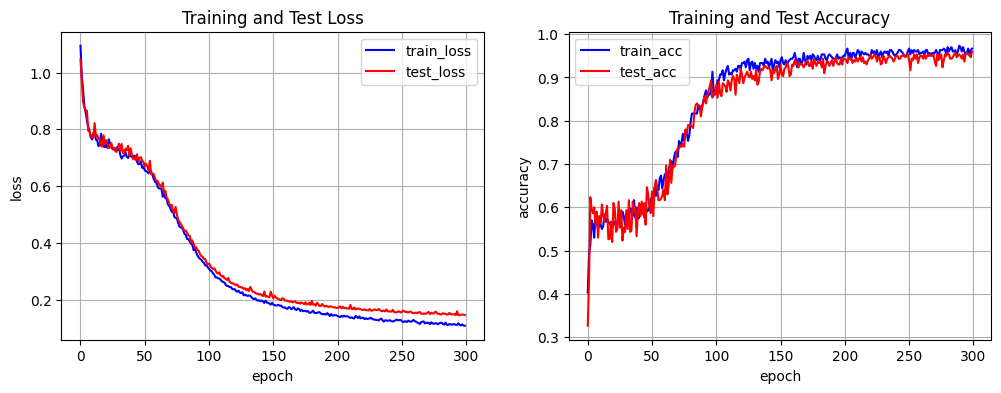

In [11]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(max_epoch), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(max_epoch), test_loss_list, color='red', linestyle='-', label='test_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and Test Loss')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(max_epoch), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(max_epoch), test_acc_list, color='red', linestyle='-', label='test_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Training and Test Accuracy')
plt.grid()

plt.show()


## 12. MNIST 데이터를 이용한 학습

In [8]:
from dezero.datasets import MNIST

train_set = dezero.datasets.MNIST(train=True, transform = None)
test_set = dezero.datasets.MNIST(train=False, transform = None)

print(len(train_set))
print(len(test_set))

Downloading: train-images-idx3-ubyte.gz
[##############################] 100.00% Done
Downloading: train-labels-idx1-ubyte.gz
[##############################] 100.00% Done
Downloading: t10k-images-idx3-ubyte.gz
[##############################] 100.00% Done
Downloading: t10k-labels-idx1-ubyte.gz
[##############################] 100.00% Done
60000
10000


In [11]:
x, t =train_set[0]
print(type(x),x.shape)
print(t)

<class 'numpy.ndarray'> (1, 28, 28)
5


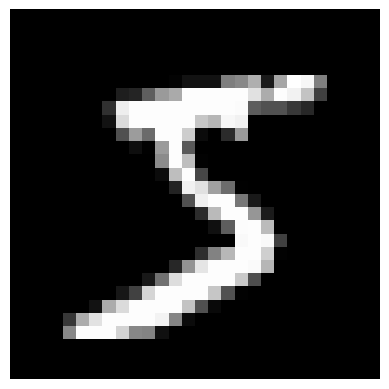

lable:  5


In [14]:
import matplotlib.pyplot as plt

x, t = train_set[0]
plt.imshow(x.reshape(28,28),cmap='gray')
plt.axis('off')
plt.show()
print('lable: ',t)

In [16]:
def f(x):
    x= x.flatten()
    x= x.astype(np.float32)
    x /= 255.0
    return x

train_set = dezero.datasets.MNIST(train=True, transform= f)
test_set = dezero.datasets.MNIST(train=False, transform= f)

x, t = train_set[0]
print(x.shape)

(784,)


In [19]:
if '__file__' in globals():
    import os, sys
    sys.path.append(os.path.join(os.path.dirname(__file__), '..'))
import math
import numpy as np
import matplotlib.pyplot as plt
import dezero
from dezero import optimizers
import dezero.functions as F
from dezero.models import MLP
from dezero.dataloaders import DataLoader

max_epoch = 5
batch_size = 100
hidden_size= 1000

train_set = dezero.datasets.MNIST(train=True)
test_set = dezero.datasets.MNIST(train=False)

train_loader = DataLoader(train_set, batch_size)
test_loader = DataLoader(test_set, batch_size, shuffle =False)


model = MLP((hidden_size, 10))
optimizer = optimizers.SGD().setup(model)

train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

for epoch in range(max_epoch):
    # Shuffle index for data
    sum_loss, sum_acc =0 ,0

    for x, t in train_loader:
        y = model(x)
        loss = F.softmax_cross_entropy(y, t)

        acc = F.accuracy(y, t)

        model.cleargrads()
        loss.backward()
        optimizer.update()

        sum_loss += float(loss.data) * len(t)
        sum_acc += float(acc.data) * len(t)


    print('epoch: {}\ntrain_loss: {:.4f}, train_accuracy: {:.4f}'.format(epoch + 1, sum_loss/len(train_set), sum_acc/len(train_set)))

    train_loss_list.append(sum_loss/len(train_set))
    train_acc_list.append(sum_acc/len(train_set))
    sum_loss, sum_acc =0 ,0

    with dezero.no_grad():
        for x,t in test_loader:
            y = model(x)
            loss = F.softmax_cross_entropy(y, t)

            acc = F.accuracy(y, t)

            sum_loss += float(loss.data) * len(t)
            sum_acc += float(acc.data) * len(t)

    print('test_loss: {:.4f}, test_accuracy: {:.4f}'.format(sum_loss/len(test_set), sum_acc/len(test_set)))
    test_loss_list.append(sum_loss/len(test_set))
    test_acc_list.append(sum_acc/len(test_set))

epoch: 1
train_loss: 1.9171, train_accuracy: 0.5568
test_loss: 1.5406, test_accuracy: 0.7568
epoch: 2
train_loss: 1.2848, train_accuracy: 0.7696
test_loss: 1.0456, test_accuracy: 0.8106
epoch: 3
train_loss: 0.9258, train_accuracy: 0.8190
test_loss: 0.7939, test_accuracy: 0.8419
epoch: 4
train_loss: 0.7405, train_accuracy: 0.8406
test_loss: 0.6569, test_accuracy: 0.8620
epoch: 5
train_loss: 0.6357, train_accuracy: 0.8546
test_loss: 0.5776, test_accuracy: 0.8679


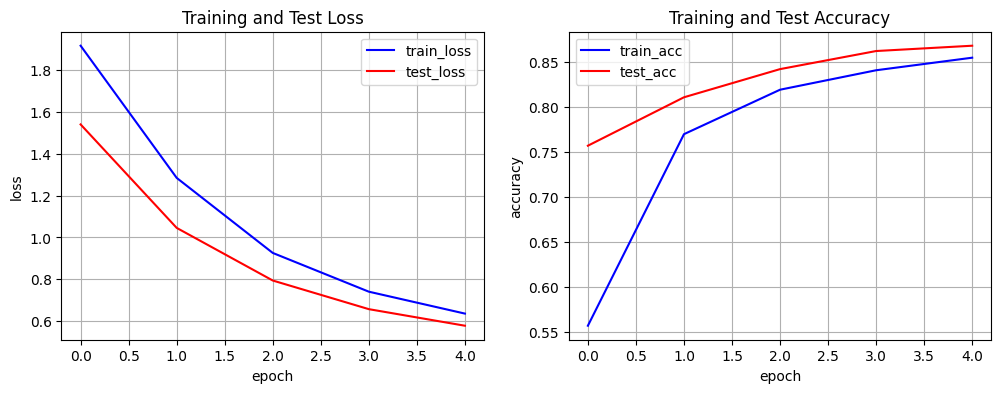

In [20]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(max_epoch), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(max_epoch), test_loss_list, color='red', linestyle='-', label='test_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and Test Loss')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(max_epoch), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(max_epoch), test_acc_list, color='red', linestyle='-', label='test_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Training and Test Accuracy')
plt.grid()

plt.show()


모델 개선하기

ReLU 함수 구현

In [ ]:
# class ReLU(Function):
#     def forward(self, x):
#         y= np.maximum(x,0.0)
#         return y
    
#     def backward(self, gy):
#         x,= self.inputs
#         mask = x.data > 0
#         gx = gy * mask
#         return gx

# def relu(x):
#     return ReLU()(x)

In [3]:
if '__file__' in globals():
    import os, sys
    sys.path.append(os.path.join(os.path.dirname(__file__), '..'))
import math
import numpy as np
import matplotlib.pyplot as plt
import dezero
from dezero import optimizers
import dezero.functions as F
from dezero.models import MLP
from dezero.dataloaders import DataLoader
from dezero.datasets import MNIST

max_epoch = 5
batch_size = 100
hidden_size= 1000

train_set = dezero.datasets.MNIST(train=True)
test_set = dezero.datasets.MNIST(train=False)

train_loader = DataLoader(train_set, batch_size)
test_loader = DataLoader(test_set, batch_size, shuffle =False)


model = MLP((hidden_size, hidden_size, 10),activation = F.relu, w_init='he')
# 은닉층 수 늘려 3층 신경망으로 변경, 활성화 함수 ReLU로 변경
#Linear class와 model MLP 수정으로 he초기값 사용할 수 있게 w_init 인자 받도록 수정
optimizer = optimizers.Adam().setup(model) # SGD에서 Adam으로 옵티마이저 변경

train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

for epoch in range(max_epoch):
    # Shuffle index for data
    sum_loss, sum_acc =0 ,0

    for x, t in train_loader:
        y = model(x)
        loss = F.softmax_cross_entropy(y, t)

        acc = F.accuracy(y, t)

        model.cleargrads()
        loss.backward()
        optimizer.update()

        sum_loss += float(loss.data) * len(t)
        sum_acc += float(acc.data) * len(t)


    print('epoch: {}\ntrain_loss: {:.4f}, train_accuracy: {:.4f}'.format(epoch + 1, sum_loss/len(train_set), sum_acc/len(train_set)))

    train_loss_list.append(sum_loss/len(train_set))
    train_acc_list.append(sum_acc/len(train_set))
    sum_loss, sum_acc =0 ,0

    with dezero.no_grad():
        for x,t in test_loader:
            y = model(x)
            loss = F.softmax_cross_entropy(y, t)

            acc = F.accuracy(y, t)

            sum_loss += float(loss.data) * len(t)
            sum_acc += float(acc.data) * len(t)

    print('test_loss: {:.4f}, test_accuracy: {:.4f}'.format(sum_loss/len(test_set), sum_acc/len(test_set)))
    test_loss_list.append(sum_loss/len(test_set))
    test_acc_list.append(sum_acc/len(test_set))

epoch: 1
train_loss: 0.1913, train_accuracy: 0.9420
test_loss: 0.1094, test_accuracy: 0.9666
epoch: 2
train_loss: 0.0718, train_accuracy: 0.9771
test_loss: 0.0764, test_accuracy: 0.9764
epoch: 3
train_loss: 0.0484, train_accuracy: 0.9839
test_loss: 0.0796, test_accuracy: 0.9756
epoch: 4
train_loss: 0.0355, train_accuracy: 0.9885
test_loss: 0.0741, test_accuracy: 0.9786
epoch: 5
train_loss: 0.0272, train_accuracy: 0.9911
test_loss: 0.0733, test_accuracy: 0.9795


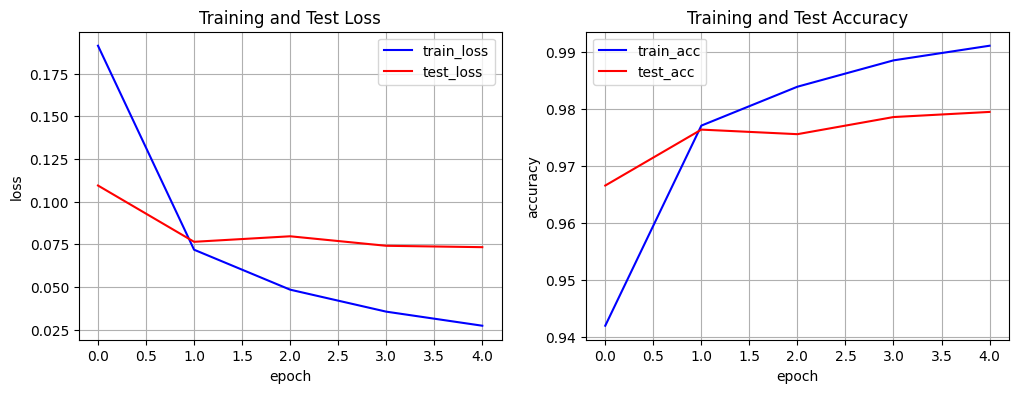

In [4]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(max_epoch), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(max_epoch), test_loss_list, color='red', linestyle='-', label='test_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and Test Loss')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(max_epoch), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(max_epoch), test_acc_list, color='red', linestyle='-', label='test_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Training and Test Accuracy')
plt.grid()

plt.show()


## 13. GPU 사용하기

In [5]:
import cupy as cp

x =cp.arange(6).reshape(2,3)
print(x)

y=x.sum(axis=1)
print(y)

[[0 1 2]
 [3 4 5]]
[ 3 12]


In [8]:
n= np.array([1,2,3])
c= cp.asarray(n)
assert type(c == cp.ndarray)

c= cp.array([1,2,3])
n=cp.asnumpy(c)
assert type(n) == np.ndarray

In [10]:
x= np.array([1,2,3])
xp = cp.get_array_module(x)
assert xp == np

x= cp.array([1,2,3])
xp = cp.get_array_module(x)
assert xp == cp

In [ ]:
if '__file__' in globals():
    import os, sys
    sys.path.append(os.path.join(os.path.dirname(__file__), '..'))
import time
import dezero
import dezero.functions as F
from dezero import optimizers
from dezero import DataLoader
from dezero.models import MLP

max_epoch = 5
batch_size = 100

train_set = dezero.datasets.MNIST(train=True)
train_loader = DataLoader(train_set, batch_size)
model = MLP((1000, 10))
optimizer = optimizers.SGD().setup(model)

# GPU mode
if dezero.cuda.gpu_enable:
    train_loader.to_gpu()
    model.to_gpu()

for epoch in range(max_epoch):
    start = time.time()
    sum_loss = 0

    for x, t in train_loader:
        y = model(x)
        loss = F.softmax_cross_entropy(y, t)
        model.cleargrads()
        loss.backward()
        optimizer.update()
        sum_loss += float(loss.data) * len(t)

    elapsed_time = time.time() - start
    print('epoch: {}, loss: {:.4f}, time: {:.4f}[sec]'.format(
        epoch + 1, sum_loss / len(train_set), elapsed_time))

## 14. 모델 저장 및 읽어오기

In [12]:
x= np.array([1,2,3])
np.save('test.npy',x)

x= np.load('test.npy')
print(x)

[1 2 3]


In [19]:
x1= np.array([1,2,3])
x2= np.array([4,5,6])

np.savez('test.npz',x1=x1,x2=x2)

arrays = np.load('test.npz')

x1=arrays['x1']
x2=arrays['x2']
print(x1)
print(x2)


[1 2 3]
[4 5 6]


In [20]:
x1= np.array([1,2,3])
x2= np.array([4,5,6])
data= {'x1':x1, 'x2':x2}

np.savez('test.npz',**data)

arrays = np.load('test.npz')

x1=arrays['x1']
x2=arrays['x2']
print(x1)
print(x2)


[1 2 3]
[4 5 6]


In [2]:
import dezero.layers as L
layer =L.Layer()
l1= L.Layer()
l1.p1=L.Parameter(np.array(1))
layer.l1=l1

layer.p2=L.Parameter(np.array(2))
layer.p3=L.Parameter(np.array(3))

In [4]:
# def _flatten_parmas(self, params_dict, parent_key=''):
#     for name in self._params:
#         obj = self.__dict__[name]
#         key = parent_key + '/' + name if parent_key else name

#         if isinstance(obj, Layer):
#             obj._flatten_params(parmas_dict, key)
#         else:
#             params_dict[key] = obj

params_dict = {}
layer._flatten_params(params_dict)
print(params_dict)

{'p2': variable(2), 'p3': variable(3), 'l1/p1': variable(1)}


In [ ]:
if '__file__' in globals():
    import os, sys
    sys.path.append(os.path.join(os.path.dirname(__file__), '..'))
import time
import dezero
import dezero.functions as F
from dezero import optimizers
from dezero import DataLoader
from dezero.models import MLP

max_epoch = 5
batch_size = 100

train_set = dezero.datasets.MNIST(train=True)
train_loader = DataLoader(train_set, batch_size)
model = MLP((1000, 10))
optimizer = optimizers.SGD().setup(model)

# 가중치 불러오기
if os.path.exists('my_mlp.npz'):
    model.load_weights('my_mlp.npz')

# GPU mode
if dezero.cuda.gpu_enable:
    train_loader.to_gpu()
    model.to_gpu()

for epoch in range(max_epoch):
    start = time.time()
    sum_loss = 0

    for x, t in train_loader:
        y = model(x)
        loss = F.softmax_cross_entropy(y, t)
        model.cleargrads()
        loss.backward()
        optimizer.update()
        sum_loss += float(loss.data) * len(t)

    elapsed_time = time.time() - start
    print('epoch: {}, loss: {:.4f}, time: {:.4f}[sec]'.format(
        epoch + 1, sum_loss / len(train_set), elapsed_time))

# 가중치 저장하기
model.save_weights('my_mlp.npz')

DropOut 구현

In [3]:
# def dropout(x, dropout_ratio=0.5):
#     x = as_variable(x)

#     if dezero.Config.train:
#         xp = cuda.get_array_module(x)
#         mask = xp.random.rand(*x.shape) > dropout_ratio
#         scale = xp.array(1.0 - dropout_ratio).astype(x.dtype)
#         y = x * mask / scale
#         return y

#     else:
#         return y

from dezero import test_mode

x = np.ones(5)
print(x)

#학습 시
y = F.dropout(x)
print(y)

#테스트 시
with test_mode():
    y = F.dropout(x)
    print(y)


[1. 1. 1. 1. 1.]
variable([0. 0. 2. 0. 2.])
variable([1. 1. 1. 1. 1.])


## 15. CNN

In [4]:
def get_conv_outsize(input_size, kernel_size, stride, pad):
    return (input_size + pad * 2 - kernel_size) // stride + 1


H, W = 4, 4  # Input size
KH, KW = 3, 3  # Kernel size
SH, SW = 1, 1  # Kernel stride
PH, PW = 1, 1  # Padding size

OH = get_conv_outsize(H, KH, SH, PH)
OW = get_conv_outsize(W, KW, SW, PW)
print(OH, OW)

4 4


In [6]:
import numpy as np
import dezero.functions_conv as FC
# im2col
x1 = np.random.rand(1, 3, 7, 7)
col1 = FC.im2col(x1, kernel_size=5, stride=1, pad=0, to_matrix=True)
print(col1.shape)  # (9, 75)

x2 = np.random.rand(10, 3, 7, 7)  # 10個のデータ
kernel_size = (5, 5)
stride = (1, 1)
pad = (0, 0)
col2 = FC.im2col(x2, kernel_size, stride, pad, to_matrix=True)
print(col2.shape)  # (90, 75)


# conv2d
N, C, H, W = 1, 5, 15, 15
OC, (KH, KW) = 8, (3, 3)
x = Variable(np.random.randn(N, C, H, W))
W = np.random.randn(OC, C, KH, KW)
y = FC.conv2d_simple(x, W, b=None, stride=1, pad=1)
y.backward()
print(y.shape)  # (1, 8, 15, 15)
print(x.grad.shape)  # (1, 5, 15, 15)

(9, 75)
(90, 75)
(1, 8, 15, 15)
(1, 5, 15, 15)


In [3]:
import numpy as np
import dezero.functions as F
# im2col
x1 = np.random.rand(1, 3, 7, 7)
col1 = F.im2col(x1, kernel_size=5, stride=1, pad=0, to_matrix=True)
print(col1.shape)  # (9, 75)

x2 = np.random.rand(10, 3, 7, 7)  # 10
kernel_size = (5, 5)
stride = (1, 1)
pad = (0, 0)
col2 = F.im2col(x2, kernel_size, stride, pad, to_matrix=True)
print(col2.shape)  # (90, 75)


# conv2d
N, C, H, W = 1, 5, 15, 15
OC, (KH, KW) = 8, (3, 3)
x = Variable(np.random.randn(N, C, H, W))
W = np.random.randn(OC, C, KH, KW)
y = F.conv2d_simple(x, W, b=None, stride=1, pad=1)
y.backward()
print(y.shape)  # (1, 8, 15, 15)
print(x.grad.shape)  # (1, 5, 15, 15)

(9, 75)
(90, 75)
(1, 8, 15, 15)
(1, 5, 15, 15)


VGG NET

In [3]:
import numpy as np
from dezero.models import VGG16

model = VGG16(pretrained=True)

x= np.random.rand(1,3,224,224).astype(np.float32)
model.plot(x)

Downloading: vgg16.npz


[##############################] 100.00% Done


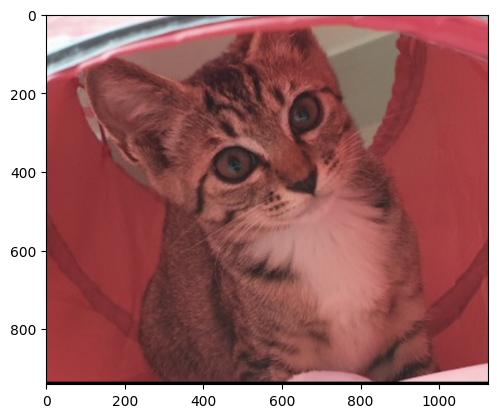

In [5]:
from PIL import Image
import matplotlib.pyplot as plt

img_path = '/home/myhwang/deep-learning-from-scratch-3/cat.PNG'
img = Image.open(img_path)
plt.imshow(img)
plt.show()


In [8]:
import dezero
from dezero.models import VGG16

x = VGG16.preprocess(img)
print(type(x), x.shape)

<class 'numpy.ndarray'> (3, 224, 224)


In [11]:
import numpy as np
from PIL import Image
import dezero
from dezero.models import VGG16

img_path = '/home/myhwang/deep-learning-from-scratch-3/cat.PNG'
img = Image.open(img_path)

x = VGG16.preprocess(img)
x = x[np.newaxis]

model = VGG16(pretrained =True)
with dezero.test_mode():
    y = model(x)
predict_id = np.argmax(y.data)

model.plot(x, to_file='vgg.pdf')
labels = dezero.datasets.ImageNet.labels()
print(labels[predict_id])

washer, automatic washer, washing machine


## 16. RNN

In [4]:
import numpy as np
import dezero.layers as L

rnn=L.RNN(10)
x=np.random.rand(1,1)
h=rnn(x)
print(h.shape)

(1, 10)


In [5]:
from dezero import Model
import dezero.functions as F
import dezero.layers as L

class SimpleRNN(Model):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.rnn= L.RNN(hidden_size)
        self.fc=L.Linear(out_size)

    def reset_state(self):
        self.rnn.reset_state()

    def forward(self, x):
        h=self.rnn(x)
        y=self.fc(h)
        return y



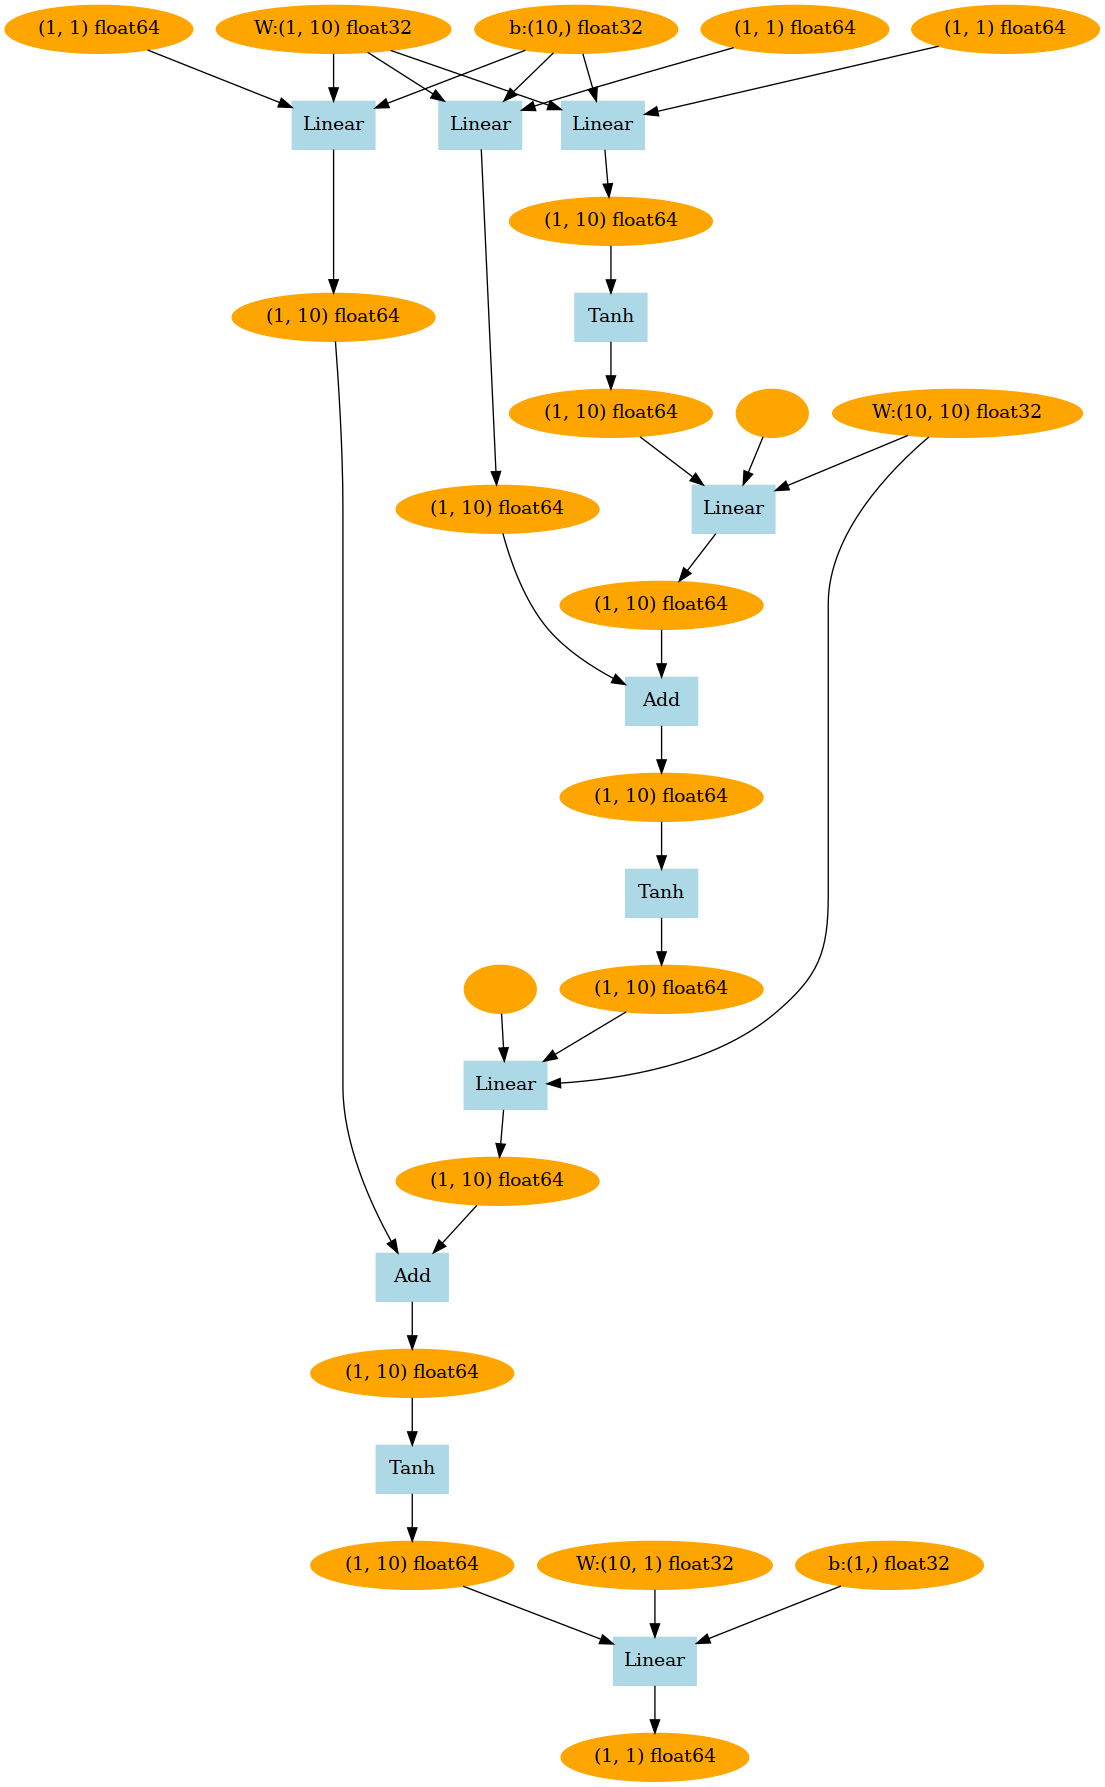

In [7]:
seq_data = [np.random.randn(1, 1) for _ in range(1000)]
xs = seq_data[0:-1]
ts = seq_data[1:]

model=SimpleRNN(10,1)
loss, cnt = 0, 0
for x, t in zip(xs, ts):
    y=model(x)
    loss+=F.mean_squared_error(y, t)

    cnt+=1

    if cnt == 2:
        model.cleargrads()
        loss.backward()
        break

model.plot(x)

In [2]:
# Hyperparameters
max_epoch = 100
hidden_size = 100
bptt_length = 30

train_set = dezero.datasets.SinCurve(train=True)
seqlen = len(train_set)


class SimpleRNN(Model):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.rnn = L.RNN(hidden_size)
        self.fc = L.Linear(out_size)

    def reset_state(self):
        self.rnn.reset_state()

    def __call__(self, x):
        h = self.rnn(x)
        y = self.fc(h)
        return y


model = SimpleRNN(hidden_size, 1)
optimizer = dezero.optimizers.Adam().setup(model)

# Start training.
for epoch in range(max_epoch):
    model.reset_state()
    loss, count = 0, 0

    for x, t in train_set:
        x = x.reshape(1, 1)
        y = model(x)
        loss += F.mean_squared_error(y, t)
        count += 1

        if count % bptt_length == 0 or count == seqlen:
            model.cleargrads()
            loss.backward()
            loss.unchain_backward()
            optimizer.update()

    avg_loss = float(loss.data) / count
    print('| epoch %d | loss %f' % (epoch + 1, avg_loss))



| epoch 1 | loss 0.293749
| epoch 2 | loss 0.044751
| epoch 3 | loss 0.025256
| epoch 4 | loss 0.005582
| epoch 5 | loss 0.003250
| epoch 6 | loss 0.002698
| epoch 7 | loss 0.002325
| epoch 8 | loss 0.002163
| epoch 9 | loss 0.002003
| epoch 10 | loss 0.002043
| epoch 11 | loss 0.002250
| epoch 12 | loss 0.002904
| epoch 13 | loss 0.004275
| epoch 14 | loss 0.005609
| epoch 15 | loss 0.005044
| epoch 16 | loss 0.003858
| epoch 17 | loss 0.003702
| epoch 18 | loss 0.004283
| epoch 19 | loss 0.004996
| epoch 20 | loss 0.005112
| epoch 21 | loss 0.004590
| epoch 22 | loss 0.004136
| epoch 23 | loss 0.004072
| epoch 24 | loss 0.004253
| epoch 25 | loss 0.004421
| epoch 26 | loss 0.004410
| epoch 27 | loss 0.004257
| epoch 28 | loss 0.004106
| epoch 29 | loss 0.004039
| epoch 30 | loss 0.004040
| epoch 31 | loss 0.004055
| epoch 32 | loss 0.004044
| epoch 33 | loss 0.004003
| epoch 34 | loss 0.003951
| epoch 35 | loss 0.003903
| epoch 36 | loss 0.003864
| epoch 37 | loss 0.003833
| epoch 38

NameError: name 'plt' is not defined

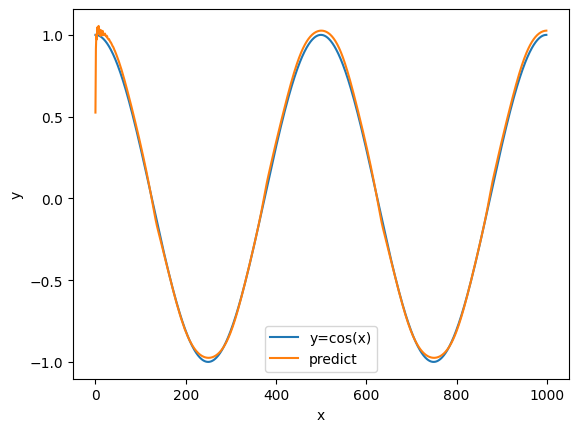

In [5]:
import matplotlib.pyplot as plt
# Plot
xs = np.cos(np.linspace(0, 4 * np.pi, 1000))
model.reset_state()
pred_list = []

with dezero.no_grad():
    for x in xs:
        x = np.array(x).reshape(1, 1)
        y = model(x)
        pred_list.append(float(y.data))

plt.plot(np.arange(len(xs)), xs, label='y=cos(x)')
plt.plot(np.arange(len(xs)), pred_list, label='predict')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

## 16. LSTM

In [ ]:
# class SeqDataLoader(DataLoader):
#     def __init__(self, dataset, batch_size, gpu=False):
#         super().__init__(dataset=dataset, batch_size=batch_size, shuffle=False, gpu=gpu)

#     def __next__(self):
#         if self.iteration >= self.max_iter:
#             self.reset()
#             raise StopIteration

#         jump = self.data_size // self.batch_size
#         batch_index = [(i * jump + self.iteration) %
#                        self.data_size for i in range(self.batch_size)]

#         batch = [self.dataset[i] for i in batch_index]

#         xp = cuda.cupy if self.gpu else np
#         x = xp.array([example[0] for example in batch])
#         t = xp.array([example[1] for example in batch])

#         self.iteration += 1
#         return x, t

# class LSTM(Layer):
#     def __init__(self, hidden_size, in_size=None):
#         super().__init__()

#         H, I = hidden_size, in_size
#         self.x2f = Linear(H, in_size=I)
#         self.x2i = Linear(H, in_size=I)
#         self.x2o = Linear(H, in_size=I)
#         self.x2u = Linear(H, in_size=I)
#         self.h2f = Linear(H, in_size=H, nobias=True)
#         self.h2i = Linear(H, in_size=H, nobias=True)
#         self.h2o = Linear(H, in_size=H, nobias=True)
#         self.h2u = Linear(H, in_size=H, nobias=True)
#         self.reset_state()

#     def reset_state(self):
#         self.h = None
#         self.c = None

#     def forward(self, x):
#         if self.h is None:
#             f = F.sigmoid(self.x2f(x))
#             i = F.sigmoid(self.x2i(x))
#             o = F.sigmoid(self.x2o(x))
#             u = F.tanh(self.x2u(x))
#         else:
#             f = F.sigmoid(self.x2f(x) + self.h2f(self.h))
#             i = F.sigmoid(self.x2i(x) + self.h2i(self.h))
#             o = F.sigmoid(self.x2o(x) + self.h2o(self.h))
#             u = F.tanh(self.x2u(x) + self.h2u(self.h))

#         if self.c is None:
#             c_new = (i * u)
#         else:
#             c_new = (f * self.c) + (i * u)

#         h_new = o * F.tanh(c_new)

#         self.h, self.c = h_new, c_new
#         return h_new

| epoch 1 | loss 0.545465
| epoch 2 | loss 0.423717
| epoch 3 | loss 0.319065
| epoch 4 | loss 0.232954
| epoch 5 | loss 0.165415
| epoch 6 | loss 0.115450
| epoch 7 | loss 0.081742
| epoch 8 | loss 0.062658
| epoch 9 | loss 0.055724
| epoch 10 | loss 0.057214
| epoch 11 | loss 0.062691
| epoch 12 | loss 0.068381
| epoch 13 | loss 0.072007
| epoch 14 | loss 0.072670
| epoch 15 | loss 0.070391
| epoch 16 | loss 0.065733
| epoch 17 | loss 0.059527
| epoch 18 | loss 0.052672
| epoch 19 | loss 0.045974
| epoch 20 | loss 0.040052
| epoch 21 | loss 0.035290
| epoch 22 | loss 0.031840
| epoch 23 | loss 0.029649
| epoch 24 | loss 0.028517
| epoch 25 | loss 0.028150
| epoch 26 | loss 0.028227
| epoch 27 | loss 0.028450
| epoch 28 | loss 0.028584
| epoch 29 | loss 0.028475
| epoch 30 | loss 0.028056
| epoch 31 | loss 0.027332
| epoch 32 | loss 0.026365
| epoch 33 | loss 0.025253
| epoch 34 | loss 0.024101
| epoch 35 | loss 0.023004
| epoch 36 | loss 0.022036
| epoch 37 | loss 0.021236
| epoch 38

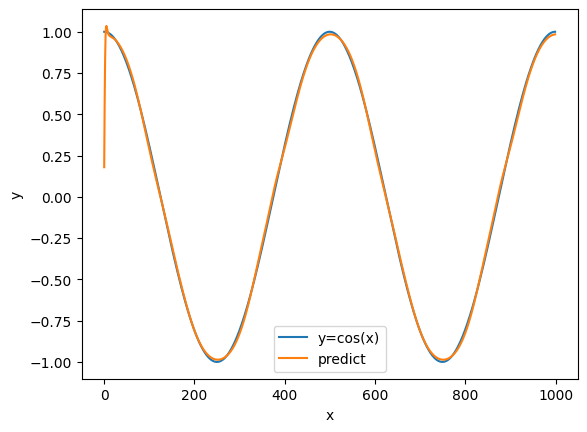

In [2]:
if '__file__' in globals():
    import os, sys
    sys.path.append(os.path.join(os.path.dirname(__file__), '..'))
import numpy as np
import matplotlib.pyplot as plt
import dezero
from dezero import Model
from dezero import SeqDataLoader
import dezero.functions as F
import dezero.layers as L


max_epoch = 100
batch_size = 30
hidden_size = 100
bptt_length = 30

train_set = dezero.datasets.SinCurve(train=True)
dataloader = SeqDataLoader(train_set, batch_size=batch_size)
seqlen = len(train_set)


class BetterRNN(Model):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.rnn = L.LSTM(hidden_size)
        self.fc = L.Linear(out_size)

    def reset_state(self):
        self.rnn.reset_state()

    def __call__(self, x):
        y = self.rnn(x)
        y = self.fc(y)
        return y

model = BetterRNN(hidden_size, 1)
optimizer = dezero.optimizers.Adam().setup(model)

for epoch in range(max_epoch):
    model.reset_state()
    loss, count = 0, 0

    for x, t in dataloader:
        y = model(x)
        loss += F.mean_squared_error(y, t)
        count += 1

        if count % bptt_length == 0 or count == seqlen:
            model.cleargrads()
            loss.backward()
            loss.unchain_backward()
            optimizer.update()
    avg_loss = float(loss.data) / count
    print('| epoch %d | loss %f' % (epoch + 1, avg_loss))

# Plot
xs = np.cos(np.linspace(0, 4 * np.pi, 1000))
model.reset_state()
pred_list = []

with dezero.no_grad():
    for x in xs:
        x = np.array(x).reshape(1, 1)
        y = model(x)
        pred_list.append(float(y.data))

plt.plot(np.arange(len(xs)), xs, label='y=cos(x)')
plt.plot(np.arange(len(xs)), pred_list, label='predict')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

***

In [1]:
from dezero import *
import contextlib
import numpy as np
import graphviz
import dezero.functions as F
import dezero.layers as L
from dezero import optimizers